## Download and install all necessary libraries and modules

In [0]:
!nvidia-smi

Sun Apr 26 12:38:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%shell

# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uq_xox48
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uq_xox48
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275298 sha256=8beadd86692dbebe32aca6c8024ba379591f37b73c0bfa5878bd800a20b3daaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-qr2qms_f/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


## Mount drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Import all necessary modules

In [0]:
import os
import shutil
import subprocess
from tqdm import tqdm

from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection

from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Defining the dataset

In [0]:
class VOC2012Dataset(VOCDetection):    
    def __getitem__(self, index):

        # temporarily disable transforms
        transforms = self.transforms
        self.transforms = None
        
        img, target = super().__getitem__(index)
        annot = target['annotation']
        objs = annot['object'] if type(annot['object']) == list else [annot['object']]

        labels = []
        boxes = []

        for obj in objs:
            labels.append(self.CLASSES.index(obj['name']))
            bndbox = obj['bndbox']
            boxes.append([
                float(bndbox['xmin']),  
                float(bndbox['ymin']),  
                float(bndbox['xmax']),  
                float(bndbox['ymax'])
            ])
        
        image_id = torch.tensor([index])
        labels = torch.tensor(labels, dtype=torch.int64)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(objs),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Activate transforms again
        self.transforms = transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    @property
    def CLASSES(self):
        return [
        '__background__', 
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'pottedplant',
        'sheep',
        'sofa',
        'train',
        'tvmonitor']

## Download & extract & explore the dataset

In [0]:
dataset = VOC2012Dataset(root='.', download=True, image_set='trainval')

boxes
tensor([[ 46.,  11., 500., 333.],
        [ 62., 190.,  83., 243.]])
torch.Size([2, 4])

labels
tensor([19, 15])
torch.Size([2])
['train', 'person']

image_id
tensor([1])
torch.Size([1])

area
tensor([146188.,   1113.])
torch.Size([2])

iscrowd
tensor([0, 0])
torch.Size([2])



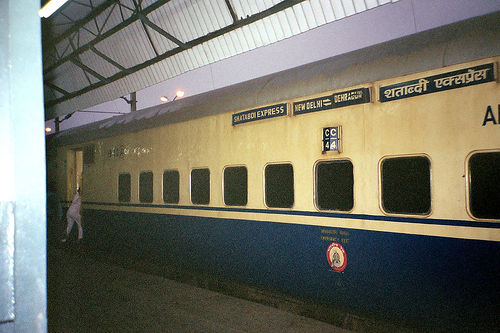

In [0]:
img, target = dataset[1]

for key, value in target.items():
    print(key, value, value.shape, sep='\n')
    if key == 'labels':
        print([dataset.CLASSES[l] for l in value])
    print()

img

## Defining the model

In [0]:
def get_instance_detection_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
train_dataset = VOC2012Dataset(root='.', download=False, image_set='train', transforms=get_transform(train=True))
test_dataset = VOC2012Dataset(root='.', download=False, image_set='val', transforms=get_transform(train=False))

In [0]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = len(train_dataset.CLASSES) + 1

# get the model using our helper function
# model = get_instance_segmentation_model(num_classes)
model = get_instance_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, weight_decay=1e-3)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# train for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=400)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

## Save model

In [0]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

model_path = '/gdrive/My Drive/trained_models/fasterrcnn.pkl'

In [0]:
# save_model(model, model_path)

## Load pre-trained model

In [0]:
model = load_model(model, model_path).to(device)

## Test model

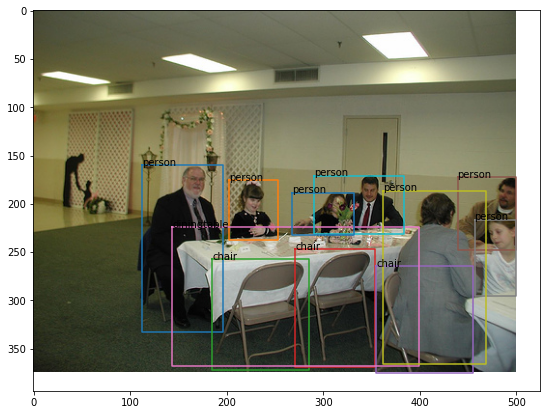

In [0]:
# pick one image from the test set
img, _ = train_dataset[8]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

mask = prediction['scores'] >= 0.8
boxes = prediction['boxes'][mask]
labels = prediction['labels'][mask]



plt.figure(figsize=(17, 7))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
for i in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[i, :]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1])
    label = train_dataset.CLASSES[labels[i].item()]
    plt.text(x1, y1, label)

## Create folders

In [0]:
dataset = VOC2012Dataset(root='.', download=False, image_set='val', transforms=get_transform(train=False))

In [0]:
root_dir = 'crops'
shutil.rmtree(root_dir)
os.mkdir(root_dir)
for class_name in dataset.CLASSES[1:]:
    os.mkdir(os.path.join(root_dir, class_name))

## Crop images

In [0]:
counter = 1
pil_trans = torchvision.transforms.ToPILImage()

for i in tqdm(range(len(dataset))):
    img, _ = dataset[i]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    mask = prediction['scores'] >= 0.9

    boxes = prediction['boxes'][mask]
    labels = prediction['labels'][mask]

    for i in range(boxes.shape[0]):
        x1, y1, x2, y2 = list(map(int, boxes[i, :]))
        cropped = img[:, y1:y2, x1:x2]
        label = train_dataset.CLASSES[labels[i].item()]
        file_path = os.path.join(root_dir, label, str(counter)+'.jpg')

        with open(file_path, 'wb') as f:
            img_to_save = pil_trans(img[:, y1:y2, x1:x2])
            img_to_save.save(f)
        
        counter += 1

100%|██████████| 5823/5823 [08:09<00:00, 11.89it/s]


## Archive result

In [0]:
def archive_folder(folder_path):
    archive_name = os.path.basename(folder_path) + '.zip'
    
    print('Achiving...')
    try:
        subprocess.call(['zip', '-r', archive_name, folder_path])
    except Exception as e:
        print(f'Failed to archive folder {folder_path}:\n', e)
    else:
        print('Archived sucessfully.')
    

archive_folder(root_dir)

Achiving...
Archived sucessfully.


## Copy archive to google drive

In [0]:
!cp crops.zip /gdrive/My\ Drive/